In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
load_dotenv()

WD = os.getenv('working_directory')

# TENSORFLOW

Dans cette partie sur tensorflow, nous allons essayer d'améliorer les prédictions des modèles scikit learn en utilisant le modèle Long Short Term Memory (LSTM).

Le LSTM est une variante des réseaux de neuronnes récurrent (RNN), c'est à dire que les neurones utilisent leur sortie comme un nouvel input.
Ce type de modèle est généralement exposé à l'explosion ou la disparition du gradient à cause de leur aspect récursif.

Cependant, le LSTM permet de régler ce problème en instaurant une cellule d'état. Cette cellule comporte 3 portes : porte d'oublie (% de la mémoire long terme oubliée), la porte d'entrée (création d'une mémoire long terme) et porte de sortie (création de mémoire court terme). A chaque observation, le neurone met à jour l'état de la cellule afin de récupérer l'effet long terme (tendance par exemple) et l'effet court terme (de volatilité dans notre cas).

Le LSTM est donc particulièrement utilisé pour effectuer des prédictions de séries temporelles et c'est ce pourquoi nous allons l'utiliser.

Nous allons d'abord utiliser seulement l'évolution de la variable Close_price, le prix de fermeture de chaque bougies et ce pour plusieurs intervalles différents : 1 jour (1d), 6 heures(6h) et 1 heure (1h).
Nous utiliserons ensuite les autres variables permettant de créer les datasets v1 pour tenter d'améliorer le modèle.

## CLOSE PRICE SEULEMENT, en 1d (Daily)

### PRE PROCESSING

Le LSTM est un réseau de neuronnes qui demande une partie importante de preprocessing. Dans cette partie, nous devrons mettre en forme notre jeu de données afin de l'adapter au traitement du LSTM.
Pour ce faire, nous définissons `build_window_matrix_one_var` qui construit une matrice de dimension (a, b, c) avec a le nombre d'observation, b le nombre d'interval (WINDOW_SIZE) sur lequel nous voulons entrainer et c le nombre de variable.

La dimension b, nous permet de régler la fenêtre d'entrainement. 

Dans ce cas, nous sommes en daily (journalier) et nous utilisons une semaine de données pour faire la prédiction sur le prochain jour donc WINDOW_SIZE = 7.

    Exemple de format:   X                                                   y
            1 obs   [[n-6], [n-5], [n-4], [n-3], [n-2], [n-1], [n]]     [[n+1]]


In [67]:
# fonctions communes aux différents modèles
def load_data(name):
    """
    Load un dataframe depuis un fichier csv data/name.csv
    """
    return pd.read_csv(f'{WD}/data/{name}.csv') 

def get_date(df):
    """
    Récupère la date
    """
    return df['Open_time'].copy()

def df_to_numpy(df):
    """
    Transforme le dataframe en numpy array
    """
    return df.to_numpy()

def train_test_val(X, y, date, train_size):
    """
    Effectue les splits de train, val et test en fonction du train_size
    """
    q_train_size = int(len(X)*train_size)
    q_val_test_size = int(len(X)*(train_size+(1-train_size)/2))

    X_train, y_train = X[:q_train_size], y[:q_train_size]
    X_val, y_val = X[q_train_size:q_val_test_size], y[q_train_size:q_val_test_size]
    X_test, y_test = X[q_val_test_size:], y[q_val_test_size:]

    date_numpy = df_to_numpy(date)
    date_train, date_val, date_test = date_numpy[:q_train_size], date_numpy[q_train_size:q_val_test_size], date_numpy[q_val_test_size:]
    return date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test

def main_pre_processing(name, is_one_var):
    """
    Effectue tous le preprocessing
    Renvoie X_train, y_train, X_val, y_val, X_test, y_test pour le dataset name
    """
    df = load_data(name)
    date = get_date(df)
    if is_one_var:
        df = get_close_price(df)
        X, y, scaler_features, scaler_target = build_window_matrix_one_var(df, window_size=WINDOW_SIZE)
    else:
        df = rearrange_data(df)
        X, y, scaler_features, scaler_target = build_window_matrix_multi_var(df, window_size=WINDOW_SIZE)
    return train_test_val(X, y, date, train_size=0.8), scaler_features, scaler_target

In [68]:
## Fonctions propres au modèle pour 1 seule variable Close_price
def get_close_price(df):
    """
    Extrait seulement le prix de cloture de la journée
    """
    return df['Close_price'].copy()

def build_window_matrix_one_var(df, window_size):
    """
    Construit la matrice (a, b, c) 
        a : # observations
        b : # intervals
        c : # variables
    """
    scaler = MinMaxScaler()

    df_numpy = df_to_numpy(df).reshape(len(df), -1)
    df_numpy_scaled = scaler.fit_transform(df_numpy)
    
    X = []
    y = []
    for i in range(len(df_numpy_scaled)-window_size):
        row = [a for a in df_numpy_scaled[i:i+window_size]]
        X.append(row)
        y.append(df_numpy_scaled[i+window_size])

    return np.array(X).astype(np.float32), np.array(y).astype(np.float32), scaler, scaler

#### Pre processing du dataframe dataset_raw_1d

In [69]:
data_name = "dataset_raw_1d"
is_one_var = True
WINDOW_SIZE = 7
(date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var)
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')


X_train : (394, 7, 1)
y_train : (394, 1)
X_val : (49, 7, 1)
y_val : (49, 1)
X_test : (50, 7, 1)
y_test : (50, 1)


Format de X_train : 394 observations, 7 jours de données glissante, 1 variable Close_price

Format de y_train : 394 observations, 1 variable Close_price pour le (WINDOW_SIZE+1 : 8ème jour)

Les formats de tous les jeux de données sont correctes, nous pouvons passer à l'entrainement du modèle.

### TRAINING

In [76]:
## Fonctions communes aux différents modèles pour l'entrainement
def prepare_model(name, n_features):
    """
    Set up le model
    """
    model = Sequential([Input((WINDOW_SIZE, n_features)),
                        LSTM(64),
                        Dense(32, activation='relu'),
                        Dense(32, activation='relu'),
                        Dense(1)
                        ], name=name)                       
    
    return model

def prepare_checkpoint(name):
    """
    """
    return ModelCheckpoint(f'{WD}/src/model/models/{name}/', save_best_only=True, save_format='tf', monitor='loss')

def train(model, learning_rate):
    """
    """
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])
    return model

def fit(model, cp, X_train, y_train, X_val, y_val, N_EPOCHS):
    """
    """
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=N_EPOCHS, callbacks=[cp])
    return model

def main_training_model(model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS):

    cp = prepare_checkpoint(name=model_name)
    model = prepare_model(name=model_name,n_features=X_train.shape[2])
    model = train(model, 0.001)
    model = fit(model, cp, X_train, y_train, X_val, y_val, N_EPOCHS)

#### Training du modèle Close_price-dataset_raw_1d-100

In [77]:
N_EPOCHS = 100
model_name = "Close_price"
data_name = "dataset_raw_1d"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

main_training_model(full_model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS)

Epoch 1/100
10/13 [======================>.......] - ETA: 0s - loss: 0.0872 - root_mean_squared_error: 0.2953

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 9s 577ms/step - loss: 0.0756 - root_mean_squared_error: 0.2749 - val_loss: 0.0423 - val_root_mean_squared_error: 0.2056
Epoch 2/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0142 - root_mean_squared_error: 0.1193

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 438ms/step - loss: 0.0137 - root_mean_squared_error: 0.1171 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 3/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0973

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 531ms/step - loss: 0.0098 - root_mean_squared_error: 0.0991 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157
Epoch 4/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0079 - root_mean_squared_error: 0.0887

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 474ms/step - loss: 0.0076 - root_mean_squared_error: 0.0870 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0786
Epoch 5/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0728

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 7s 545ms/step - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 6/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0686

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 437ms/step - loss: 0.0047 - root_mean_squared_error: 0.0684 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779
Epoch 7/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0664

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 539ms/step - loss: 0.0046 - root_mean_squared_error: 0.0679 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0571
Epoch 8/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0681

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 484ms/step - loss: 0.0045 - root_mean_squared_error: 0.0670 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 9/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0610

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 7s 562ms/step - loss: 0.0036 - root_mean_squared_error: 0.0602 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649
Epoch 10/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0591

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 439ms/step - loss: 0.0035 - root_mean_squared_error: 0.0594 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0684
Epoch 11/100
13/13 [==============================] - 0s 13ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640
Epoch 12/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0036 - root_mean_squared_error: 0.0596 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 13/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0595

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 7s 554ms/step - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591
Epoch 14/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0569

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 527ms/step - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0626
Epoch 15/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0633
Epoch 16/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0539

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 496ms/step - loss: 0.0028 - root_mean_squared_error: 0.0534 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779
Epoch 17/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0035 - root_mean_squared_error: 0.0590 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0698
Epoch 18/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0033 - root_mean_squared_error: 0.0576 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0665
Epoch 19/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0033 - root_mean_squared_error: 0.0572 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0667
Epoch 20/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0030 - root_mean_squared_error: 0.0545 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628
Epoch 21/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0029 - root_mean_squared_error: 0.0540 - val_loss: 0.0041 - val_root_m

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 451ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 23/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0540
Epoch 24/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0645
Epoch 25/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0918
Epoch 26/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0032 - root_mean_squared_error: 0.0565 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0957
Epoch 27/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0025 - root_mean_squared_error: 0.0503 - val_loss: 0.0056 - val_root_m

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 7s 548ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0725
Epoch 40/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0454

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 511ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0780
Epoch 41/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0703
Epoch 42/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0022 - root_mean_squared_error: 0.0467 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0583
Epoch 43/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0552
Epoch 44/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598
Epoch 45/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0023 - root_mean_squared_error: 0.0483 - val_loss: 0.0054 - val_root_m

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 450ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 48/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0644
Epoch 49/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 50/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0023 - root_mean_squared_error: 0.0484 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0673
Epoch 51/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0644
Epoch 52/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0052 - val_root_m

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 434ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0643
Epoch 54/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0653
Epoch 55/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0620
Epoch 56/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0738
Epoch 57/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0677
Epoch 58/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414 - val_loss: 0.0031 - val_root_m

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 7s 558ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
Epoch 63/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0635
Epoch 64/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0648
Epoch 65/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 66/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0584
Epoch 67/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0015 - root_mean_squared_error: 0.0392 - val_loss: 0.0042 - val_root_m

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 464ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0740
Epoch 69/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0683
Epoch 70/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0684
Epoch 71/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 72/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0016 - root_mean_squared_error: 0.0399 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0556
Epoch 73/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0032 - val_root_m

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 536ms/step - loss: 0.0013 - root_mean_squared_error: 0.0367 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0622
Epoch 78/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0368

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 7s 542ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0655
Epoch 79/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608
Epoch 80/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 81/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712
Epoch 82/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 83/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376 - val_loss: 0.0038 - val_root_m

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 5s 443ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 86/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591
Epoch 87/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0647
Epoch 88/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0535
Epoch 89/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600
Epoch 90/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0341   

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Close_price-dataset_raw_1d-100/assets


13/13 [==============================] - 6s 524ms/step - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0543
Epoch 91/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0482
Epoch 92/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611
Epoch 93/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649
Epoch 94/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0612
Epoch 95/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 0.0035 - val_root_m

### ANALYSE DES RÉSULTATS

In [73]:
# Fonctions communes aux différentes modèles
def create_directory_if_not_exists(directory_name):
    """
    Crée un répertoire s'il n'existe pas déjà.

    Parameters:
    directory_name (str): Le nom du répertoire à créer.
    """
    if not os.path.exists(directory_name):
        try:
            os.makedirs(directory_name)
            print(f"Répertoire '{directory_name}' créé avec succès.")
        except Exception as e:
            print(f"Erreur lors de la création du répertoire '{directory_name}': {e}")
    else:
        print(f"Le répertoire '{directory_name}' existe déjà.")


def load(name):
    """
    """
    return load_model(f'{WD}/src/model/models/{name}/', custom_objects={'LSTM': LSTM})

def predict(model, X):
    """
    """
    return model.predict(X)

def inverse_scaler(scaler, array):
    """
    """
    return scaler.inverse_transform(array)

def plot(df, model_name, is_train):
    """
    """
    ticks_to_display = np.linspace(0, len(df) - 1, 5, dtype=int)  # 5 indices répartis uniformément
    create_directory_if_not_exists(f'{WD}/figure/{model_name}')
    plt.clf()
    plt.plot(df['Date'], df['Actual N+1'], label='Actuals') 
    plt.plot(df['Date'], df['Predictions N+1'], label='Predictions')
    plt.xticks(ticks_to_display, df["Date"].iloc[ticks_to_display], rotation=45)
    plt.title(f"Comparaison Réel et Prédiction pour le jeu de {'train' if is_train==1 else 'test' if is_train==0 else 'validation'}")
    plt.legend()
    plt.savefig(f"{WD}/figure/{model_name}/COMPARAISON_{'train_' if is_train==1 else 'test_' if is_train==0 else 'val_'}prediction.png")
    plt.show()

In [74]:
## Fonctions propres au modèle pour 1 seule variable Close_price en Daily
def analyze(date, X, y, predictions):
    """
    """
    df_analyze = pd.concat([
                            pd.DataFrame(date), 
                            pd.DataFrame(X[:, WINDOW_SIZE-1, 0]), 
                            pd.DataFrame(y.reshape(-1)), 
                            pd.DataFrame(predictions)
                            ], axis=1)



    df_analyze.columns = ['Date', 'Actual N', 'Actual N+1', 'Predictions N+1']

    df_analyze['Actual UP or DOWN'] = pd.DataFrame((df_analyze['Actual N+1'] > df_analyze['Actual N']).astype(int))
    df_analyze['Predicted UP or DOWN'] = pd.DataFrame((df_analyze['Predictions N+1'] > df_analyze['Actual N']).astype(int))

    cm = confusion_matrix(df_analyze['Actual UP or DOWN'], df_analyze['Predicted UP or DOWN'])
    acc = cm[0][0] + cm[1][1]
    tot = cm.sum()
    print(f'Accuracy : {acc/tot*100}%')
    cm_df = pd.DataFrame(cm, index=['Actual DOWN', 'Actual UP'], columns=['Predicted DOWN', 'Predicted UP'])
    
    return df_analyze, cm_df

def analyze_for_data(model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train):

    if is_train==1:
        date = date_train
        X = X_train
        y = y_train
    elif is_train==0:
        date = date_test
        X = X_test
        y = y_test
    else :
        date = date_val
        X = X_val
        y = y_val

    pred = predict(model, X)
    X_reshape = X.reshape(X.shape[0], -1)
    X_inv_scaled = inverse_scaler(scaler_features, X_reshape)
    X_inv_scaled = np.array(X_inv_scaled)
    X = X_inv_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])
    print("X_shape :", X.shape)
    #y = inverse_scaler(scaler_target, [y])
    y = inverse_scaler(scaler_target, y)
    print("y_shape :",y.shape)
    predictions = inverse_scaler(scaler_target, pred)

    df_analyze, cm_df = analyze(date, X, y, predictions)
    print(f"#####{'TRAIN' if is_train==1 else 'TEST' if is_train==0 else 'VAL'}#####\n",df_analyze.head(15).to_string())
    print(f'######MATRICE DE CONFUSION#######\n {cm_df}')
    plot(df_analyze, model.name, is_train)

def main_analyze_model(is_train):
    model_name = "Close_price-dataset_raw_1d-100"
    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    (date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var=True)

    analyze_for_data(loaded_model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train)

#### Analyse du modèle Close_price-dataset_raw_1d-100

13/13 [==============================] - 1s 4ms/step
X_shape : (394, 7, 1)
y_shape : (394, 1)
Accuracy : 53.55329949238579%
#####TRAIN#####
           Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2023-08-28  25971.208984  25826.019531     27148.421875                  0                     1
1   2023-08-29  25826.019531  25792.099609     27069.214844                  0                     1
2   2023-08-30  25792.099609  25759.949219     27036.968750                  0                     1
3   2023-08-31  25759.949219  26255.001953     27022.746094                  1                     1
4   2023-09-01  26255.001953  25910.500000     27110.902344                  0                     1
5   2023-09-02  25910.500000  25901.609375     27111.662109                  0                     1
6   2023-09-03  25901.609375  25841.609375     27105.335938                  0                     1
7   2023-09-04  25841.609375  25162.519531     2708

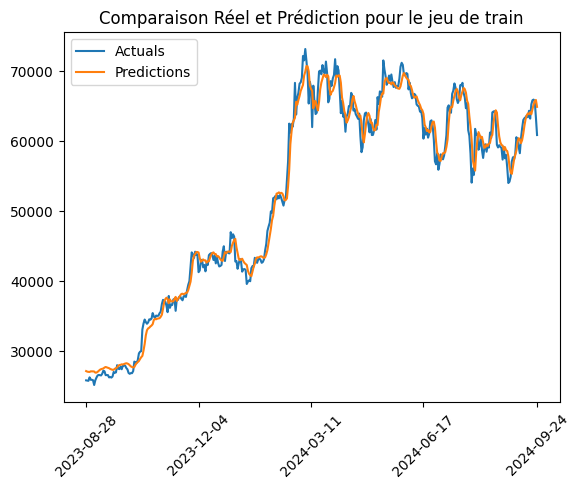

2/2 [==============================] - 1s 6ms/step
X_shape : (49, 7, 1)
y_shape : (49, 1)
Accuracy : 48.97959183673469%
#####VAL#####
           Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2024-09-25  60805.781250  60649.277344     63012.222656                  0                     1
1   2024-09-26  60649.277344  60752.710938     61659.250000                  1                     1
2   2024-09-27  60752.710938  62086.000000     61005.371094                  1                     1
3   2024-09-28  62086.000000  62058.000000     61367.171875                  0                     0
4   2024-09-29  62058.000000  62819.910156     61815.308594                  1                     0
5   2024-09-30  62819.910156  62224.000000     62551.921875                  0                     0
6   2024-10-01  62224.000000  62160.492188     62743.179688                  0                     1
7   2024-10-02  62160.492188  60636.019531     62687.2265

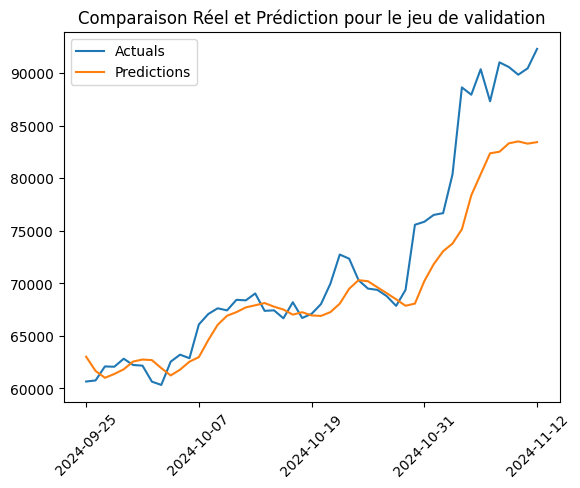

2/2 [==============================] - 1s 6ms/step
X_shape : (50, 7, 1)
y_shape : (50, 1)
Accuracy : 50.877192982456144%
#####TEST#####
           Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2024-11-13  92310.789062  94286.554688     84032.187500                  1                     0
1   2024-11-14  94286.554688  98317.117188     85109.804688                  1                     0
2   2024-11-15  98317.117188  98891.992188     86967.750000                  1                     0
3   2024-11-16  98891.992188  97672.398438     88499.992188                  0                     0
4   2024-11-17  97672.398438  97900.031250     89003.085938                  1                     0
5   2024-11-18  97900.031250  93010.007812     89126.687500                  0                     0
6   2024-11-19  93010.007812  91965.164062     87513.695312                  0                     0
7   2024-11-20  91965.164062  95863.109375     85910.74

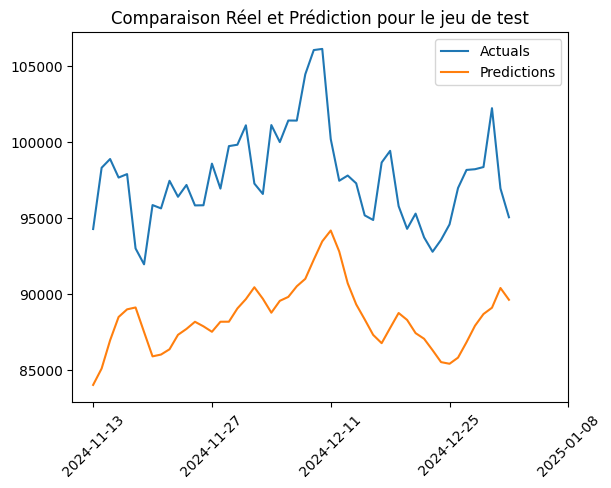

In [78]:
"is_train : 1 pour Train, 0 pour Test , autre pour val"
for is_train in (1, 2, 0):
    main_analyze_model(is_train)

## CLOSE PRICE SEULEMENT, en 6h (6 heures)

#### Pre processing du dataframe dataset_raw_6h

In [46]:
data_name = "dataset_raw_6h"
# is_one_var = True car une seule variable
is_one_var = True
#On passe la window de 7 à 7*4=28 pour garder une semaine de fenêtre 
WINDOW_SIZE = 28

(date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var)
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (1577, 28, 1)
y_train : (1577, 1)
X_val : (197, 28, 1)
y_val : (197, 1)
X_test : (198, 28, 1)
y_test : (198, 1)


#### Training du modèle Close_price-dataset_raw_6h-100

In [47]:
N_EPOCHS = 100
model_name = "Close_price"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

#main_training_model(full_model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS)

#### Analyse du modèle Close_price-dataset_raw_6h-100

In [48]:
def analyze(date, X, y, predictions):
    """
    """
    df_analyze = pd.concat([
                            pd.DataFrame(date), 
                            pd.DataFrame(X[:, WINDOW_SIZE-1, 0]), 
                            pd.DataFrame(y.reshape(-1)), 
                            pd.DataFrame(predictions)
                            ], axis=1)
    
    df_analyze.columns = ['Date', 'Actual N', 'Actual N+1', 'Predictions N+1']
    df_analyze_minuit = df_analyze
    #df_analyze_minuit = df_analyze[pd.to_datetime(df_analyze['Date']).dt.time == pd.Timestamp('00:00:00').time()]

    df_analyze_minuit['Actual UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Actual N+1'] > df_analyze_minuit['Actual N']).astype(int))
    df_analyze_minuit['Predicted UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Predictions N+1'] > df_analyze_minuit['Actual N']).astype(int))

    cm = confusion_matrix(df_analyze_minuit['Actual UP or DOWN'], df_analyze_minuit['Predicted UP or DOWN'])
    acc = cm[0][0] + cm[1][1]
    tot = cm.sum()
    print(f'Accuracy : {acc/tot*100}%')
    cm_df = pd.DataFrame(cm, index=['Actual DOWN', 'Actual UP'], columns=['Predicted DOWN', 'Predicted UP'])
    
    return df_analyze_minuit, cm_df

def main_analyze_model(is_train, model_name):
    #model_name = "Close_price-dataset_raw_6h-100"
    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    (date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var=True)

    analyze_for_data(loaded_model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train)

50/50 [==============================] - 1s 9ms/step
X_shape : (1577, 28, 1)
y_shape : (1577, 1)
Accuracy : 53.83639822447685%
#####TRAIN#####
                    Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2023-08-28 00:00:00  25971.208984  25934.439453     25975.400391                  0                     1
1   2023-08-28 06:00:00  25934.439453  25892.490234     25978.019531                  0                     1
2   2023-08-28 12:00:00  25892.490234  25907.480469     25961.318359                  1                     1
3   2023-08-28 18:00:00  25907.480469  25826.021484     25954.902344                  0                     1
4   2023-08-29 00:00:00  25826.021484  25733.310547     25920.068359                  0                     1
5   2023-08-29 06:00:00  25733.310547  25783.681641     25869.019531                  1                     1
6   2023-08-29 12:00:00  25783.681641  25749.080078     25859.302734                  

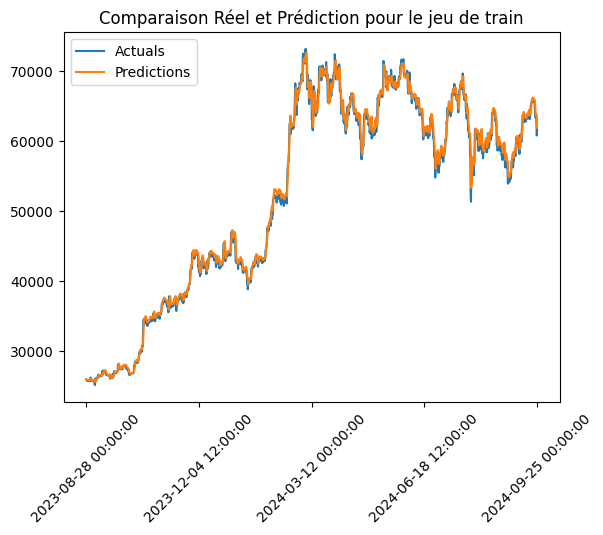

7/7 [==============================] - 1s 9ms/step
X_shape : (197, 28, 1)
y_shape : (197, 1)
Accuracy : 54.314720812182735%
#####VAL#####
                    Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2024-09-25 06:00:00  61489.710938  61164.011719     61696.496094                  0                     1
1   2024-09-25 12:00:00  61164.011719  61628.011719     61470.746094                  1                     1
2   2024-09-25 18:00:00  61628.011719  60649.281250     61650.460938                  0                     1
3   2024-09-26 00:00:00  60649.281250  61176.011719     61292.011719                  1                     1
4   2024-09-26 06:00:00  61176.011719  60764.742188     61398.257812                  0                     1
5   2024-09-26 12:00:00  60764.742188  60632.000000     61278.867188                  0                     1
6   2024-09-26 18:00:00  60632.000000  60752.714844     61163.214844                  1    

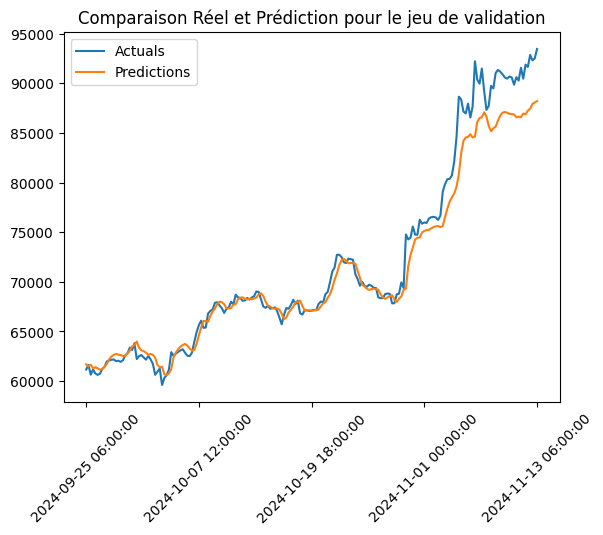

7/7 [==============================] - 1s 10ms/step
X_shape : (198, 28, 1)
y_shape : (198, 1)
Accuracy : 54.424778761061944%
#####TEST#####
                    Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2024-11-13 12:00:00  93454.656250  93916.335938     88582.273438                  1                     0
1   2024-11-13 18:00:00  93916.335938  94286.562500     88965.062500                  1                     0
2   2024-11-14 00:00:00  94286.562500  97328.000000     89318.031250                  1                     0
3   2024-11-14 06:00:00  97328.000000  97974.992188     90507.554688                  1                     0
4   2024-11-14 12:00:00  97974.992188  98048.656250     91493.070312                  1                     0
5   2024-11-14 18:00:00  98048.656250  98317.125000     92122.851562                  1                     0
6   2024-11-15 00:00:00  98317.125000  98790.968750     92561.679688                  1  

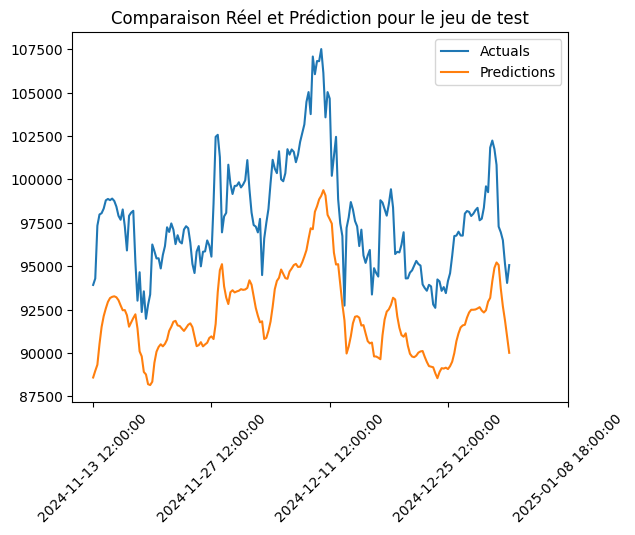

In [50]:
"is_train : 1 pour Train, 0 pour Test , autre pour val"
for is_train in (1, 2, 0):
    main_analyze_model(is_train, full_model_name)

## CLOSE PRICE SEULEMENT, en 1h (1 heure)

#### Pre processing du dataframe dataset_raw_1h

In [51]:
data_name = "dataset_raw_1h"
# is_one_var = True car une seule variable
is_one_var = True
#On passe la window de 7 à 7*4=28 pour garder une semaine de fenêtre 
WINDOW_SIZE = 7*4*6

(date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var)
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (9465, 168, 1)
y_train : (9465, 1)
X_val : (1183, 168, 1)
y_val : (1183, 1)
X_test : (1184, 168, 1)
y_test : (1184, 1)


#### Training du modèle Close_price-dataset_raw_1h-10

In [52]:
N_EPOCHS = 10
model_name = "Close_price"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

#main_training_model(full_model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS)

#### Analyse du modèle Close_price-dataset_raw_1h-10

296/296 [==============================] - 12s 40ms/step
X_shape : (9465, 168, 1)
y_shape : (9465, 1)
Accuracy : 53.312202852614895%
#####TRAIN#####
                    Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2023-08-28 00:00:00  25971.208984  25910.089844     26005.572266                  0                     1
1   2023-08-28 01:00:00  25910.089844  25908.490234     25994.892578                  0                     1
2   2023-08-28 02:00:00  25908.490234  25983.160156     25984.324219                  1                     1
3   2023-08-28 03:00:00  25983.160156  25987.558594     25991.412109                  1                     1
4   2023-08-28 04:00:00  25987.558594  25982.640625     25998.941406                  0                     1
5   2023-08-28 05:00:00  25982.640625  25934.441406     26004.457031                  0                     1
6   2023-08-28 06:00:00  25934.441406  25967.480469     25998.349609            

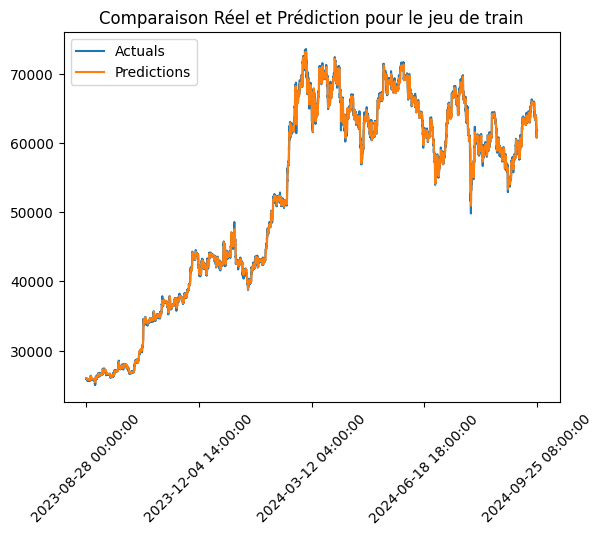

37/37 [==============================] - 2s 39ms/step
X_shape : (1183, 168, 1)
y_shape : (1183, 1)
Accuracy : 49.53508030431107%
#####VAL#####
                    Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2024-09-25 09:00:00  61806.007812  61271.250000     61677.050781                  0                     0
1   2024-09-25 10:00:00  61271.250000  61188.281250     61567.578125                  0                     1
2   2024-09-25 11:00:00  61188.281250  61164.011719     61442.074219                  0                     1
3   2024-09-25 12:00:00  61164.011719  60798.800781     61329.070312                  0                     1
4   2024-09-25 13:00:00  60798.800781  61350.000000     61128.812500                  1                     1
5   2024-09-25 14:00:00  61350.000000  61077.781250     61138.289062                  0                     0
6   2024-09-25 15:00:00  61077.781250  61874.011719     61076.875000                  

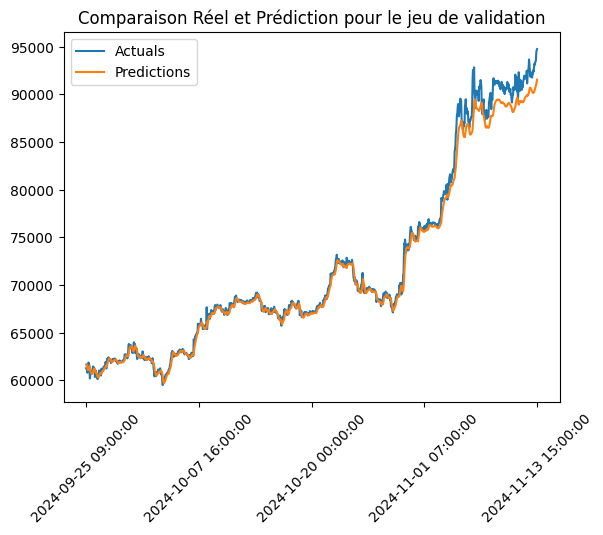

37/37 [==============================] - 3s 40ms/step
X_shape : (1184, 168, 1)
y_shape : (1184, 1)
Accuracy : 55.399408284023664%
#####TEST#####
                    Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2024-11-13 16:00:00  94739.968750  94048.000000     91759.421875                  0                     0
1   2024-11-13 17:00:00  94048.000000  93916.343750     91853.203125                  0                     0
2   2024-11-13 18:00:00  93916.343750  93684.000000     91885.273438                  0                     0
3   2024-11-13 19:00:00  93684.000000  94000.000000     91853.203125                  1                     0
4   2024-11-13 20:00:00  94000.000000  94271.992188     91847.773438                  1                     0
5   2024-11-13 21:00:00  94271.992188  94365.921875     91876.750000                  1                     0
6   2024-11-13 22:00:00  94365.921875  94160.546875     91919.507812                

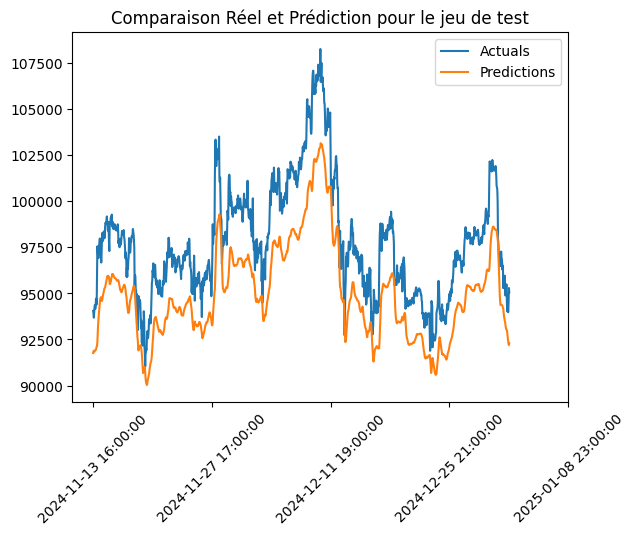

In [53]:
"is_train : 1 pour Train, 0 pour Test , autre pour val"
for is_train in (1, 2, 0):
    main_analyze_model(is_train, full_model_name)

## TOUTES LES VARIABLES, en 1d (Daily)

#### Pre processing du dataframe dataset_v1_1d

In [20]:
def get_date(df):
    return df['date_utc'].copy()

def rearrange_data(df):
    df.dropna(inplace=True)
    #df.drop('Ignore', axis=1, inplace=True)
    df.drop('Open_time', axis=1, inplace=True)
    df.drop('date_utc', axis=1, inplace=True)
    df.drop('Close_time', axis=1, inplace=True)
    columns = ['Close_price'] + [col for col in df.columns if col != 'Close_price']
    df = df[columns]
    return df

def build_window_matrix_multi_var(df, window_size):
    """
    """
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    df_numpy = df_to_numpy(df)

    X = []
    y = []
    for i in range(len(df_numpy)-window_size):
        row = [a for a in df_numpy[i:i+window_size]]
        X.append(row)
        y.append(df_numpy[i+window_size][0])

    #Scaling de X
    X = np.array(X)
    X_reshape = X.reshape(X.shape[0], -1)
    X_scaled = scaler_features.fit_transform(X_reshape)
    X_scaled = np.array(X_scaled)
    X = X_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])
    X = np.array(X)

    #Scaling de y
    y = np.array(y)
    y_reshape = y.reshape(-1, 1)
    y_scaled = scaler_target.fit_transform(y_reshape)
    y_scaled = np.array(y_scaled)
    y = y_scaled.reshape(y.shape[0],)

    return X.astype(np.float32), y.astype(np.float32), scaler_features, scaler_target

In [21]:
data_name = "dataset_v1_1d"
# is_one_var = False car toutes les variables
is_one_var = False
#On passe la window de 7 à 7*4=28 pour garder une semaine de fenêtre 
WINDOW_SIZE = 7

(date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var)
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (393, 7, 29)
y_train : (393,)
X_val : (49, 7, 29)
y_val : (49,)
X_test : (50, 7, 29)
y_test : (50,)


#### Training du modèle All_variables-dataset_v1_1d-100

In [22]:
N_EPOCHS = 100
model_name = "All_variables"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

#main_training_model(full_model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS)

#### Analyse du modèle All_variables-dataset_v1_1d-100

In [23]:
def analyze(date, X, y, predictions):
    """
    """
    df_analyze = pd.concat([
                            pd.DataFrame(date), 
                            pd.DataFrame(X[:, WINDOW_SIZE-1, 0]), 
                            pd.DataFrame(y.reshape(-1)), 
                            pd.DataFrame(predictions)
                            ], axis=1)


    df_analyze.columns = ['Date', 'Actual N', 'Actual N+1', 'Predictions N+1']

    df_analyze_minuit = df_analyze[pd.to_datetime(df_analyze['Date']).dt.time == pd.Timestamp('00:00:00').time()]

    df_analyze_minuit['Actual UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Actual N+1'] > df_analyze_minuit['Actual N']).astype(int))
    df_analyze_minuit['Predicted UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Predictions N+1'] > df_analyze_minuit['Actual N']).astype(int))
    
    cm = confusion_matrix(df_analyze_minuit['Actual UP or DOWN'], df_analyze_minuit['Predicted UP or DOWN'])
    print(cm)
    acc = cm[0][0] + cm[1][1]
    tot = cm.sum()
    print(f'Accuracy : {acc/tot*100}%')
    cm_df = pd.DataFrame(cm, index=['Actual DOWN', 'Actual UP'], columns=['Predicted DOWN', 'Predicted UP'])
    
    return df_analyze_minuit, cm_df

def analyze_for_data(model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train):

    if is_train==1:
        date = date_train
        X = X_train
        y = y_train
    elif is_train==0:
        date = date_test
        X = X_test
        y = y_test
    else :
        date = date_val
        X = X_val
        y = y_val

    print(X.shape)
    pred = predict(model, X)
    print(X.reshape(X.shape[0], -1).shape)
    X_reshape = X.reshape(X.shape[0], -1)
    X_inv_scaled = inverse_scaler(scaler_features, X_reshape)
    X_inv_scaled = np.array(X_inv_scaled)
    X = X_inv_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])
    print(X.shape)
    y = inverse_scaler(scaler_target, [y])
    print(y.shape)
    predictions = inverse_scaler(scaler_target, pred)

    df_analyze, cm_df = analyze(date, X, y, predictions)
    print(f"#####{'TRAIN' if is_train==1 else 'TEST' if is_train==2 else 'VAL'}#####\n",df_analyze)
    print(f'######MATRICE DE CONFUSION#######\n {cm_df}')
    plot(df_analyze, model.name, is_train)

def main_analyze_model(is_train, model_name):
    model_name = model_name
    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    (date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var=False)

    analyze_for_data(loaded_model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train)

(393, 7, 29)
13/13 [==============================] - 1s 5ms/step
(393, 203)
(393, 7, 29)
(1, 393)
[[123  63]
 [ 34 173]]
Accuracy : 75.31806615776081%
#####TRAIN#####
            Date      Actual N    Actual N+1  Predictions N+1  \
0    2023-08-28  25826.019531  25792.099991     25979.986328   
1    2023-08-29  25792.099609  25759.950005     25905.601562   
2    2023-08-30  25759.949219  26255.000012     26142.824219   
3    2023-08-31  26255.001953  25910.500008     26152.904297   
4    2023-09-01  25910.500000  25901.610035     26092.597656   
..          ...           ...           ...              ...   
388  2024-09-19  65173.988281  65769.949649     66443.906250   
389  2024-09-20  65769.953125  65857.999951     66199.375000   
390  2024-09-21  65858.000000  65602.010252     66000.281250   
391  2024-09-22  65602.015625  63327.588998     65276.300781   
392  2024-09-23  63327.589844  60805.780854     63773.582031   

     Actual UP or DOWN  Predicted UP or DOWN  
0              

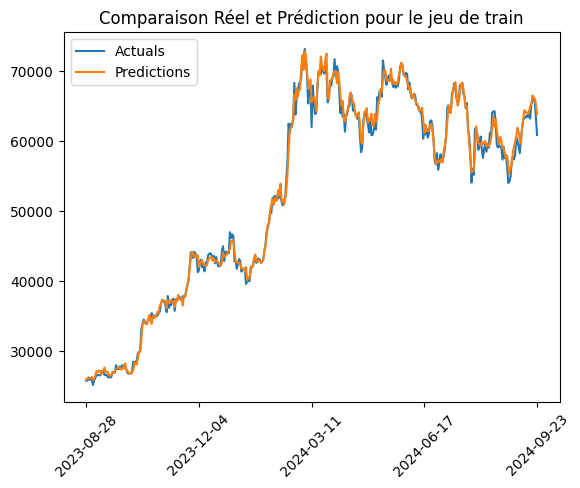

(49, 7, 29)
2/2 [==============================] - 1s 6ms/step
(49, 203)
(49, 7, 29)
(1, 49)
[[22  0]
 [27  0]]
Accuracy : 44.89795918367347%
#####TEST#####
           Date      Actual N    Actual N+1  Predictions N+1  \
0   2024-09-24  60805.781250  60649.279695     60723.886719   
1   2024-09-25  60649.277344  60752.708878     58653.789062   
2   2024-09-26  60752.710938  62085.999622     55485.746094   
3   2024-09-27  62086.000000  62058.000070     55573.785156   
4   2024-09-28  62058.000000  62819.909797     53554.417969   
5   2024-09-29  62819.910156  62223.999310     52913.082031   
6   2024-09-30  62224.000000  62160.490544     51100.101562   
7   2024-10-01  62160.492188  60636.019544     51364.136719   
8   2024-10-02  60636.019531  60326.390782     49154.941406   
9   2024-10-03  60326.390625  62540.001150     47965.613281   
10  2024-10-04  62540.000000  63206.220604     51146.382812   
11  2024-10-05  63206.222656  62870.020863     50957.265625   
12  2024-10-06  62870.0

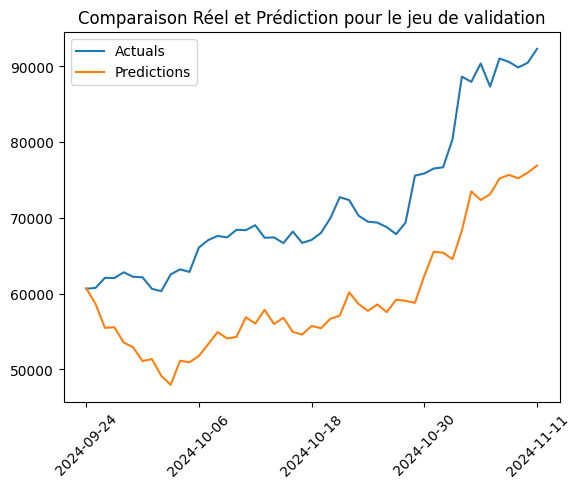

(50, 7, 29)
2/2 [==============================] - 1s 5ms/step
(50, 203)
(50, 7, 29)
(1, 50)
[[30  0]
 [28  0]]
Accuracy : 51.724137931034484%
#####VAL#####
           Date       Actual N     Actual N+1  Predictions N+1  \
0   2024-11-12   92310.789062   94286.558335     76486.273438   
1   2024-11-13   94286.554688   98317.118347     76539.515625   
2   2024-11-14   98317.117188   98891.998403     83151.320312   
3   2024-11-15   98891.992188   97672.402298     82389.007812   
4   2024-11-16   97672.398438   97900.037715     81410.765625   
5   2024-11-17   97900.031250   93010.012352     82806.976562   
6   2024-11-18   93010.007812   91965.160672     81255.718750   
7   2024-11-19   91965.164062   95863.109516     77863.007812   
8   2024-11-20   95863.109375   95643.977970     78951.460938   
9   2024-11-21   95643.976562   97459.998560     81821.523438   
10  2024-11-22   97459.992188   96407.989535     81859.664062   
11  2024-11-23   96407.984375   97185.181617     80563.265625 

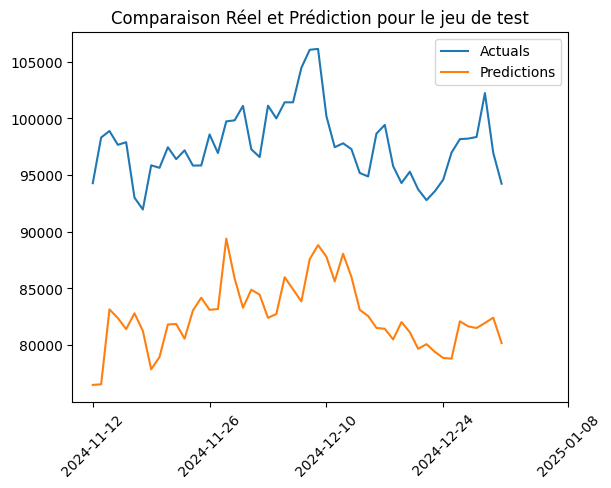

In [24]:
"is_train : 1 pour Train, 0 pour Test , autre pour val"
for is_train in (1, 2, 0):
    main_analyze_model(is_train, full_model_name)

## TOUTES LES VARIABLES, en 6h (6 heures)

#### Pre processing du dataframe dataset_v1_6h

In [57]:
def get_date(df):
    return df['date_utc'].copy()

def rearrange_data(df):
    df.dropna(inplace=True)
    #df.drop('Ignore', axis=1, inplace=True)
    #df.drop('Open_time', axis=1, inplace=True)
    df.drop('date_utc', axis=1, inplace=True)
    #df.drop('Close_time', axis=1, inplace=True)
    columns = ['Close_price'] + [col for col in df.columns if col != 'Close_price']
    df = df[columns]
    return df

def build_window_matrix_multi_var(df, window_size):
    """
    """
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    df_numpy = df_to_numpy(df)

    X = []
    y = []
    for i in range(len(df_numpy)-window_size):
        row = [a for a in df_numpy[i:i+window_size]]
        X.append(row)
        y.append(df_numpy[i+window_size][0])

    #Scaling de X
    X = np.array(X)
    X_reshape = X.reshape(X.shape[0], -1)
    X_scaled = scaler_features.fit_transform(X_reshape)
    X_scaled = np.array(X_scaled)
    X = X_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])
    X = np.array(X)

    #Scaling de y
    y = np.array(y)
    y_reshape = y.reshape(-1, 1)
    y_scaled = scaler_target.fit_transform(y_reshape)
    y_scaled = np.array(y_scaled)
    y = y_scaled.reshape(y.shape[0],)

    return X.astype(np.float32), y.astype(np.float32), scaler_features, scaler_target

In [58]:
data_name = "dataset_v1_6h"
# is_one_var = False car toutes les variables
is_one_var = False
#On passe la window de 7 à 7*4=28 pour garder une semaine de fenêtre 
WINDOW_SIZE = 7*4

(date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var)
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (1576, 28, 33)
y_train : (1576,)
X_val : (197, 28, 33)
y_val : (197,)
X_test : (198, 28, 33)
y_test : (198,)


#### Training du modèle All_variables-dataset_v1_6h-50

In [64]:
N_EPOCHS = 100
model_name = "All_variables"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

main_training_model(full_model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS)

Epoch 1/100
49/50 [============================>.] - ETA: 0s - loss: 0.0229 - root_mean_squared_error: 0.1514

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 11s 169ms/step - loss: 0.0228 - root_mean_squared_error: 0.1511 - val_loss: 0.0489 - val_root_mean_squared_error: 0.2211
Epoch 2/100
49/50 [============================>.] - ETA: 0s - loss: 8.2133e-04 - root_mean_squared_error: 0.0287

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 127ms/step - loss: 8.1961e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1895
Epoch 3/100
49/50 [============================>.] - ETA: 0s - loss: 5.4476e-04 - root_mean_squared_error: 0.0233

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 7s 152ms/step - loss: 5.4284e-04 - root_mean_squared_error: 0.0233 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1790
Epoch 4/100
49/50 [============================>.] - ETA: 0s - loss: 4.5935e-04 - root_mean_squared_error: 0.0214

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 128ms/step - loss: 4.5866e-04 - root_mean_squared_error: 0.0214 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1662
Epoch 5/100
49/50 [============================>.] - ETA: 0s - loss: 3.7681e-04 - root_mean_squared_error: 0.0194

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 123ms/step - loss: 3.7971e-04 - root_mean_squared_error: 0.0195 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1571
Epoch 6/100
49/50 [============================>.] - ETA: 0s - loss: 3.3807e-04 - root_mean_squared_error: 0.0184

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 8s 154ms/step - loss: 3.3765e-04 - root_mean_squared_error: 0.0184 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1487
Epoch 7/100
49/50 [============================>.] - ETA: 0s - loss: 3.0074e-04 - root_mean_squared_error: 0.0173

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 128ms/step - loss: 2.9934e-04 - root_mean_squared_error: 0.0173 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 8/100
49/50 [============================>.] - ETA: 0s - loss: 2.7604e-04 - root_mean_squared_error: 0.0166

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 8s 155ms/step - loss: 2.7588e-04 - root_mean_squared_error: 0.0166 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1370
Epoch 9/100
49/50 [============================>.] - ETA: 0s - loss: 2.5212e-04 - root_mean_squared_error: 0.0159

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 131ms/step - loss: 2.5128e-04 - root_mean_squared_error: 0.0159 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1254
Epoch 10/100
49/50 [============================>.] - ETA: 0s - loss: 2.1518e-04 - root_mean_squared_error: 0.0147

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 8s 154ms/step - loss: 2.1478e-04 - root_mean_squared_error: 0.0147 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1221
Epoch 11/100
49/50 [============================>.] - ETA: 0s - loss: 2.0334e-04 - root_mean_squared_error: 0.0143

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 129ms/step - loss: 2.0336e-04 - root_mean_squared_error: 0.0143 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 12/100
49/50 [============================>.] - ETA: 0s - loss: 2.0208e-04 - root_mean_squared_error: 0.0142

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 128ms/step - loss: 2.0184e-04 - root_mean_squared_error: 0.0142 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1032
Epoch 13/100
49/50 [============================>.] - ETA: 0s - loss: 1.9891e-04 - root_mean_squared_error: 0.0141

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 8s 153ms/step - loss: 1.9956e-04 - root_mean_squared_error: 0.0141 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1015
Epoch 14/100
49/50 [============================>.] - ETA: 0s - loss: 1.7901e-04 - root_mean_squared_error: 0.0134

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 128ms/step - loss: 1.7878e-04 - root_mean_squared_error: 0.0134 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 15/100
48/50 [===========================>..] - ETA: 0s - loss: 1.7779e-04 - root_mean_squared_error: 0.0133

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 7s 152ms/step - loss: 1.7709e-04 - root_mean_squared_error: 0.0133 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0993
Epoch 16/100
49/50 [============================>.] - ETA: 0s - loss: 1.5807e-04 - root_mean_squared_error: 0.0126

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 125ms/step - loss: 1.5862e-04 - root_mean_squared_error: 0.0126 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 17/100
49/50 [============================>.] - ETA: 0s - loss: 1.4861e-04 - root_mean_squared_error: 0.0122

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 7s 152ms/step - loss: 1.4888e-04 - root_mean_squared_error: 0.0122 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966
Epoch 18/100
50/50 [==============================] - 2s 31ms/step - loss: 1.7009e-04 - root_mean_squared_error: 0.0130 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0944
Epoch 19/100
49/50 [============================>.] - ETA: 0s - loss: 1.3877e-04 - root_mean_squared_error: 0.0118

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 126ms/step - loss: 1.3839e-04 - root_mean_squared_error: 0.0118 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 20/100
49/50 [============================>.] - ETA: 0s - loss: 1.3427e-04 - root_mean_squared_error: 0.0116

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 7s 149ms/step - loss: 1.3431e-04 - root_mean_squared_error: 0.0116 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0800
Epoch 21/100
50/50 [==============================] - 2s 30ms/step - loss: 1.3839e-04 - root_mean_squared_error: 0.0118 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0916
Epoch 22/100
50/50 [==============================] - 2s 30ms/step - loss: 1.3653e-04 - root_mean_squared_error: 0.0117 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0917
Epoch 23/100
50/50 [==============================] - 2s 30ms/step - loss: 1.4099e-04 - root_mean_squared_error: 0.0119 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 24/100
49/50 [============================>.] - ETA: 0s - loss: 1.2121e-04 - root_mean_squared_error: 0.0110

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 129ms/step - loss: 1.2118e-04 - root_mean_squared_error: 0.0110 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856
Epoch 25/100
49/50 [============================>.] - ETA: 0s - loss: 1.1435e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 8s 159ms/step - loss: 1.1385e-04 - root_mean_squared_error: 0.0107 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0751
Epoch 26/100
50/50 [==============================] - 2s 30ms/step - loss: 1.2618e-04 - root_mean_squared_error: 0.0112 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876
Epoch 27/100
50/50 [==============================] - ETA: 0s - loss: 1.1032e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 131ms/step - loss: 1.1032e-04 - root_mean_squared_error: 0.0105 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0843
Epoch 28/100
50/50 [==============================] - 2s 31ms/step - loss: 1.1892e-04 - root_mean_squared_error: 0.0109 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0811
Epoch 29/100
49/50 [============================>.] - ETA: 0s - loss: 1.0414e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 132ms/step - loss: 1.0449e-04 - root_mean_squared_error: 0.0102 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837
Epoch 30/100
50/50 [==============================] - 1s 30ms/step - loss: 1.2488e-04 - root_mean_squared_error: 0.0112 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0810
Epoch 31/100
49/50 [============================>.] - ETA: 0s - loss: 9.8835e-05 - root_mean_squared_error: 0.0099

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 8s 153ms/step - loss: 9.8673e-05 - root_mean_squared_error: 0.0099 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748
Epoch 32/100
50/50 [==============================] - 2s 30ms/step - loss: 1.1477e-04 - root_mean_squared_error: 0.0107 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0809
Epoch 33/100
50/50 [==============================] - 2s 31ms/step - loss: 1.3349e-04 - root_mean_squared_error: 0.0116 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0687
Epoch 34/100
50/50 [==============================] - 2s 30ms/step - loss: 1.1034e-04 - root_mean_squared_error: 0.0105 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 35/100
50/50 [==============================] - 2s 30ms/step - loss: 1.2314e-04 - root_mean_squared_error: 0.0111 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0683
Epoch 36/100
49/50 [============================>.] - ETA: 0s - loss: 8.9520e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 127ms/step - loss: 8.9159e-05 - root_mean_squared_error: 0.0094 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 37/100
50/50 [==============================] - 2s 31ms/step - loss: 9.2076e-05 - root_mean_squared_error: 0.0096 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0683
Epoch 38/100
49/50 [============================>.] - ETA: 0s - loss: 8.3445e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 7s 152ms/step - loss: 8.3691e-05 - root_mean_squared_error: 0.0091 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596
Epoch 39/100
50/50 [==============================] - 2s 31ms/step - loss: 1.0046e-04 - root_mean_squared_error: 0.0100 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0719
Epoch 40/100
50/50 [==============================] - 1s 30ms/step - loss: 1.2667e-04 - root_mean_squared_error: 0.0113 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 41/100
50/50 [==============================] - 2s 31ms/step - loss: 9.5363e-05 - root_mean_squared_error: 0.0098 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721
Epoch 42/100
50/50 [==============================] - 2s 31ms/step - loss: 1.0606e-04 - root_mean_squared_error: 0.0103 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0699
Epoch 43/100
50/50 [==============================] - 2s 31ms/step - loss: 9.1318e-05 - root_mean_squared_error: 0.0096 - val_l

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 125ms/step - loss: 8.3311e-05 - root_mean_squared_error: 0.0091 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640
Epoch 47/100
50/50 [==============================] - 2s 31ms/step - loss: 9.1206e-05 - root_mean_squared_error: 0.0096 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0643
Epoch 48/100
50/50 [==============================] - 2s 31ms/step - loss: 9.4070e-05 - root_mean_squared_error: 0.0097 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
Epoch 49/100
50/50 [==============================] - 2s 31ms/step - loss: 9.8886e-05 - root_mean_squared_error: 0.0099 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0622
Epoch 50/100
50/50 [==============================] - 2s 30ms/step - loss: 9.5274e-05 - root_mean_squared_error: 0.0098 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0681
Epoch 51/100
50/50 [==============================] - 2s 31ms/step - loss: 9.0488e-05 - root_mean_squared_error: 0.0095 - val_l

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 8s 156ms/step - loss: 7.9868e-05 - root_mean_squared_error: 0.0089 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0583
Epoch 54/100
50/50 [==============================] - 1s 30ms/step - loss: 9.0080e-05 - root_mean_squared_error: 0.0095 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 55/100
50/50 [==============================] - 2s 30ms/step - loss: 9.0474e-05 - root_mean_squared_error: 0.0095 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 56/100
50/50 [==============================] - 2s 30ms/step - loss: 8.9527e-05 - root_mean_squared_error: 0.0095 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589
Epoch 57/100
50/50 [==============================] - 2s 30ms/step - loss: 8.5824e-05 - root_mean_squared_error: 0.0093 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0593
Epoch 58/100
50/50 [==============================] - 2s 31ms/step - loss: 1.2018e-04 - root_mean_squared_error: 0.0110 - val_l

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 126ms/step - loss: 7.5057e-05 - root_mean_squared_error: 0.0087 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0583
Epoch 68/100
50/50 [==============================] - 2s 30ms/step - loss: 9.0234e-05 - root_mean_squared_error: 0.0095 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0525
Epoch 69/100
50/50 [==============================] - 2s 31ms/step - loss: 9.2605e-05 - root_mean_squared_error: 0.0096 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0534
Epoch 70/100
50/50 [==============================] - 2s 31ms/step - loss: 8.8497e-05 - root_mean_squared_error: 0.0094 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 71/100
50/50 [==============================] - 2s 30ms/step - loss: 1.0139e-04 - root_mean_squared_error: 0.0101 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 72/100
49/50 [============================>.] - ETA: 0s - loss: 7.2360e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 8s 157ms/step - loss: 7.2121e-05 - root_mean_squared_error: 0.0085 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0507
Epoch 73/100
50/50 [==============================] - 2s 31ms/step - loss: 8.3096e-05 - root_mean_squared_error: 0.0091 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0515
Epoch 74/100
50/50 [==============================] - 2s 30ms/step - loss: 9.4345e-05 - root_mean_squared_error: 0.0097 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492
Epoch 75/100
50/50 [==============================] - 2s 30ms/step - loss: 8.3893e-05 - root_mean_squared_error: 0.0092 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 76/100
50/50 [==============================] - 2s 31ms/step - loss: 8.2979e-05 - root_mean_squared_error: 0.0091 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0555
Epoch 77/100
50/50 [==============================] - 2s 31ms/step - loss: 8.1097e-05 - root_mean_squared_error: 0.0090 - val_l

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-100/assets


50/50 [==============================] - 6s 130ms/step - loss: 7.0296e-05 - root_mean_squared_error: 0.0084 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0547
Epoch 90/100
50/50 [==============================] - 2s 30ms/step - loss: 7.8463e-05 - root_mean_squared_error: 0.0089 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 91/100
50/50 [==============================] - 1s 30ms/step - loss: 8.9260e-05 - root_mean_squared_error: 0.0094 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 92/100
50/50 [==============================] - 2s 30ms/step - loss: 9.3590e-05 - root_mean_squared_error: 0.0097 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 93/100
50/50 [==============================] - 2s 31ms/step - loss: 7.6469e-05 - root_mean_squared_error: 0.0087 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 94/100
50/50 [==============================] - 2s 30ms/step - loss: 9.1880e-05 - root_mean_squared_error: 0.0096 - val_l

#### Analyse du modèle All_variables-dataset_v1_6h-50

In [62]:
def analyze(date, X, y, predictions):
    """
    """
    df_analyze = pd.concat([
                            pd.DataFrame(date), 
                            pd.DataFrame(X[:, WINDOW_SIZE-1, 0]), 
                            pd.DataFrame(y.reshape(-1)), 
                            pd.DataFrame(predictions)
                            ], axis=1)


    df_analyze.columns = ['Date', 'Actual N', 'Actual N+1', 'Predictions N+1']
    df_analyze_minuit = df_analyze
    #df_analyze_minuit = df_analyze[pd.to_datetime(df_analyze['Date']).dt.time == pd.Timestamp('00:00:00').time()]

    df_analyze_minuit['Actual UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Actual N+1'] > df_analyze_minuit['Actual N']).astype(int))
    df_analyze_minuit['Predicted UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Predictions N+1'] > df_analyze_minuit['Actual N']).astype(int))
    
    cm = confusion_matrix(df_analyze_minuit['Actual UP or DOWN'], df_analyze_minuit['Predicted UP or DOWN'])
    print(cm)
    acc = cm[0][0] + cm[1][1]
    tot = cm.sum()
    print(f'Accuracy : {acc/tot*100}%')
    cm_df = pd.DataFrame(cm, index=['Actual DOWN', 'Actual UP'], columns=['Predicted DOWN', 'Predicted UP'])
    
    return df_analyze_minuit, cm_df

def analyze_for_data(model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train):

    if is_train==1:
        date = date_train
        X = X_train
        y = y_train
    elif is_train==0:
        date = date_test
        X = X_test
        y = y_test
    else :
        date = date_val
        X = X_val
        y = y_val

    print(X.shape)
    pred = predict(model, X)
    print(X.reshape(X.shape[0], -1).shape)
    X_reshape = X.reshape(X.shape[0], -1)
    X_inv_scaled = inverse_scaler(scaler_features, X_reshape)
    X_inv_scaled = np.array(X_inv_scaled)
    X = X_inv_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])
    print(X.shape)
    y = inverse_scaler(scaler_target, [y])
    print(y.shape)
    predictions = inverse_scaler(scaler_target, pred)

    df_analyze, cm_df = analyze(date, X, y, predictions)
    print(f"#####{'TRAIN' if is_train==1 else 'TEST' if is_train==2 else 'VAL'}#####\n",df_analyze)
    print(f'######MATRICE DE CONFUSION#######\n {cm_df}')
    plot(df_analyze, model.name, is_train)

def main_analyze_model(is_train, model_name):
    model_name = model_name
    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    (date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var=False)

    analyze_for_data(loaded_model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train)

(1576, 28, 33)
50/50 [==============================] - 1s 10ms/step
(1576, 924)
(1576, 28, 33)
(1, 1576)
[[352 412]
 [372 440]]
Accuracy : 50.25380710659898%
#####TRAIN#####
                      Date      Actual N    Actual N+1  Predictions N+1  \
0     2023-08-28 00:00:00  25934.439453  25892.490004     26970.855469   
1     2023-08-28 06:00:00  25892.490234  25907.480035     28212.677734   
2     2023-08-28 12:00:00  25907.480469  25826.020008     26881.203125   
3     2023-08-28 18:00:00  25826.021484  25733.309982     27579.826172   
4     2023-08-29 00:00:00  25733.310547  25783.679993     28513.636719   
...                   ...           ...           ...              ...   
1571  2024-09-23 18:00:00  63327.593750  63749.989642     63160.281250   
1572  2024-09-24 00:00:00  63749.992188  63733.999131     64530.894531   
1573  2024-09-24 06:00:00  63734.000000  62151.988833     64780.222656   
1574  2024-09-24 12:00:00  62151.992188  60805.779681     63398.984375   
1575  2024

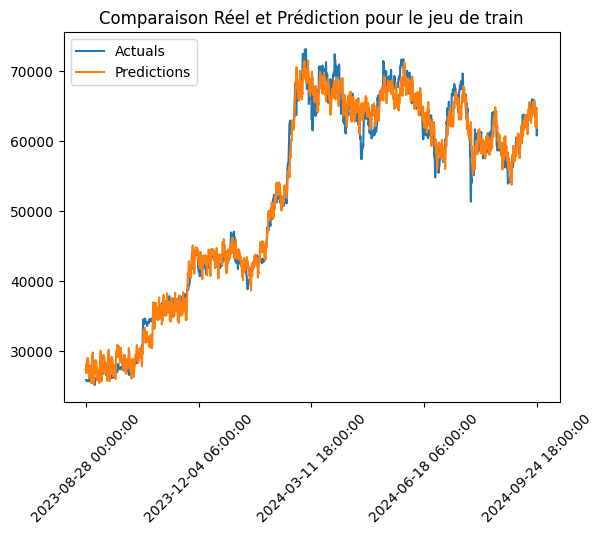

(197, 28, 33)
7/7 [==============================] - 1s 10ms/step
(197, 924)
(197, 28, 33)
(1, 197)
[[ 86   0]
 [111   0]]
Accuracy : 43.65482233502538%
#####TEST#####
                     Date      Actual N    Actual N+1  Predictions N+1  \
0    2024-09-25 00:00:00  61489.710938  61164.010327     60666.195312   
1    2024-09-25 06:00:00  61164.011719  61628.010009     58103.187500   
2    2024-09-25 12:00:00  61628.011719  60649.280772     55787.386719   
3    2024-09-25 18:00:00  60649.281250  61176.010572     55023.718750   
4    2024-09-26 00:00:00  61176.011719  60764.740804     56061.214844   
..                   ...           ...           ...              ...   
192  2024-11-12 00:00:00  91877.000000  91652.018467     71909.273438   
193  2024-11-12 06:00:00  91652.015625  92853.760858     72934.039062   
194  2024-11-12 12:00:00  92853.757812  92310.790234     72552.937500   
195  2024-11-12 18:00:00  92310.789062  92505.469066     72322.671875   
196  2024-11-13 00:00:00  92

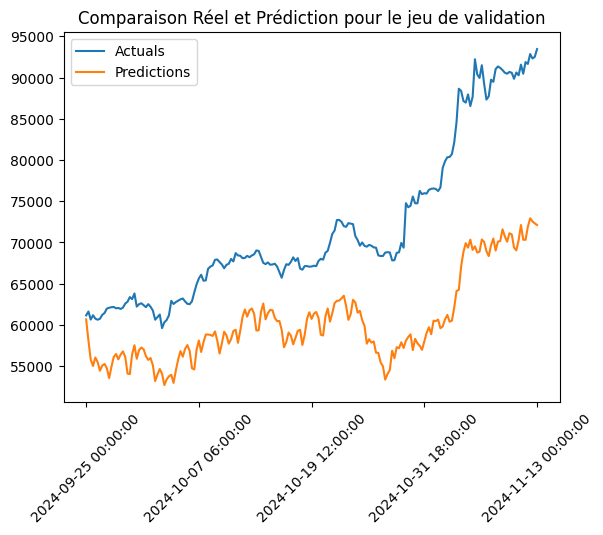

(198, 28, 33)
7/7 [==============================] - 1s 10ms/step
(198, 924)
(198, 28, 33)
(1, 198)
[[124   0]
 [103   0]]
Accuracy : 54.62555066079295%
#####VAL#####
                     Date      Actual N    Actual N+1  Predictions N+1  \
0    2024-11-13 06:00:00  93454.656250  93916.339664     72538.929688   
1    2024-11-13 12:00:00  93916.335938  94286.560740     71031.414062   
2    2024-11-13 18:00:00  94286.562500  97328.002139     71305.000000   
3    2024-11-14 00:00:00  97328.000000  97974.989616     73509.390625   
4    2024-11-14 06:00:00  97974.992188  98048.650020     73343.601562   
..                   ...           ...           ...              ...   
222  2025-01-07 18:00:00           NaN           NaN              NaN   
223  2025-01-08 00:00:00           NaN           NaN              NaN   
224  2025-01-08 06:00:00           NaN           NaN              NaN   
225  2025-01-08 12:00:00           NaN           NaN              NaN   
226  2025-01-08 18:00:00     

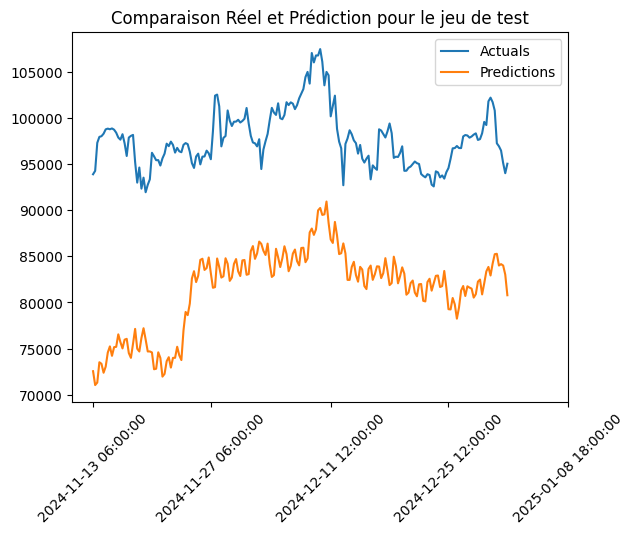

In [63]:
"is_train : 1 pour Train, 0 pour Test , autre pour val"
for is_train in (1, 2, 0):
    main_analyze_model(is_train, full_model_name)